In [1]:
from const import globs

In [2]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM

D, V, M, k, gamma = globs('l')

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

From now on let's use the following simulated data for further testing

In [4]:
from simulator import Simulator

In [5]:
test_data = Simulator(D, V, M, k, gamma, seed=1967)  # Man on the moon
test_data.generate_all_data()

random_initial_data = Simulator(D, V, M, k, gamma, seed=1969)  # Woodstock Music Festival
random_initial_data.generate_non_informative(test_data.W)

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z
Success: G transformed from K
Success: E transformed from Z
Success: C transformed from Z


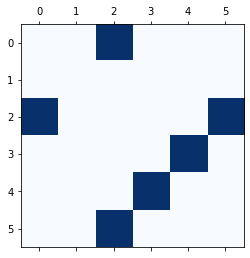

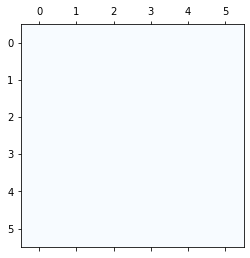

In [6]:
plt.matshow(test_data.G, cmap='Blues')
plt.matshow(random_initial_data.G, cmap='Blues')

In [7]:
random_initial_data.Z[0]

array([[ 1.,  3.,  4.,  0., -1.],
       [ 5.,  1., -1., -1., -1.],
       [ 3.,  4., -1., -1., -1.],
       [ 3., -1., -1., -1., -1.],
       [ 3.,  1.,  3., -1., -1.],
       [ 5.,  5.,  2.,  4.,  4.],
       [-1., -1., -1., -1., -1.],
       [ 4.,  5.,  0., -1., -1.],
       [ 4.,  0., -1., -1., -1.],
       [ 5., -1., -1., -1., -1.],
       [ 4., -1., -1., -1., -1.],
       [ 3., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [ 3., -1., -1., -1., -1.],
       [ 5.,  4.,  4.,  5.,  1.],
       [ 0., -1., -1., -1., -1.]])

In [8]:
test_data.Z[0]

array([[ 0.,  3.,  0.,  0., -1.],
       [ 0.,  0., -1., -1., -1.],
       [ 3.,  0., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 0.,  0.,  0., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1.],
       [ 0.,  3.,  0., -1., -1.],
       [ 1.,  0., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 5., -1., -1., -1., -1.]])

# 2. MC SAMPLER

## 2.1.1 Sampling Z (MCMC Sampler)

### Task:

You must implement a function that receives matrices $W$, $\Theta_{i+1}$ and $B_i$ and generates the next $Z_{i+1}$ and $B_{i+1}$.

In [9]:
from samplers import MC_sample_Z
from binder_loss import binder_loss

## 2.1.2 Z Sampling Tests

### MC_sample_Z tests

In [10]:
Z_copy = random_initial_data.Z.copy()
E_copy = random_initial_data.E.copy()
C_copy = random_initial_data.C.copy()

W_copy = test_data.W.copy()
Theta_copy = test_data.Theta.copy()
B_copy = test_data.B.copy()


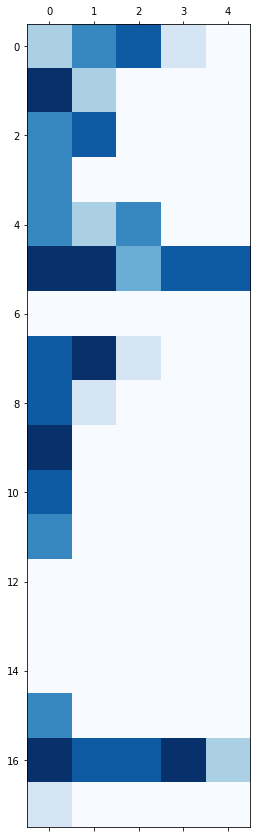

In [11]:
plt.matshow(Z_copy[0], cmap='Blues')

In [12]:
# Check that the function runs with no issues, without side effects but on Z

Z_sample, E_sample, C_sample = MC_sample_Z(Z_copy, W_copy, Theta_copy, B_copy, E_copy, C_copy, debug=True)

assert np.any(Z_copy != random_initial_data.Z)
assert np.all(W_copy == test_data.W)
assert np.all(Theta_copy == test_data.Theta)
assert np.all(B_copy == test_data.B)

Z_sample[0]

array([[ 5.,  0.,  4.,  5., -1.],
       [ 4.,  0., -1., -1., -1.],
       [ 5.,  4., -1., -1., -1.],
       [ 5., -1., -1., -1., -1.],
       [ 4.,  4.,  4., -1., -1.],
       [ 0.,  5.,  3.,  0.,  4.],
       [-1., -1., -1., -1., -1.],
       [ 4.,  4.,  5., -1., -1.],
       [ 4.,  4., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 5., -1., -1., -1., -1.],
       [ 4., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [ 4., -1., -1., -1., -1.],
       [ 4.,  4.,  4.,  5.,  4.],
       [ 5., -1., -1., -1., -1.]])

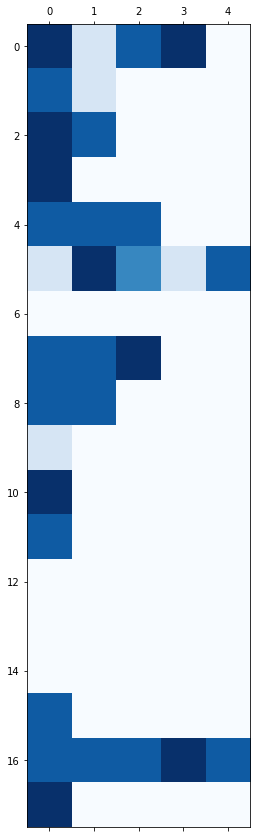

In [13]:
plt.matshow(Z_sample[0], cmap='Blues')

### Binder loss tests

In [14]:
%%time
# Testing
binder_loss(Z_sample, test_data.Z, debug=True)  # Note that all possible pairs are 460320

Error: 246857
Max error: 20250000
Error %: 1.2190469135802469
CPU times: user 130 ms, sys: 22.3 ms, total: 152 ms
Wall time: 154 ms


0.012190469135802469

In [15]:
%%time
# This MUST return zero
binder_loss(Z_sample, Z_sample, debug=True)

Error: 0
Max error: 20250000
Error %: 0.0
CPU times: user 138 ms, sys: 10.9 ms, total: 149 ms
Wall time: 150 ms


0.0

In [16]:
# Shifting indexes
Z_sample_shifted = Z_sample.copy()
for i in range(k):
    replace_value = (i + 1) % k 
    Z_sample_shifted[Z_sample == i] = replace_value

# This MUST return zero
%time binder_loss(Z_sample, Z_sample_shifted, debug=True)

Error: 0
Max error: 20250000
Error %: 0.0
CPU times: user 138 ms, sys: 6.33 ms, total: 144 ms
Wall time: 146 ms


0.0

In [17]:
binder_loss(Z_sample[1], test_data.Z[1])

0.046419753086419754

### MC_sample_Z cycle test

In [22]:
%%time

# Check that the Sampler works properly (This will take a while)

errors = []
E_errors = []
C_errors = []
matrix_changes = []
burn_in = 1000
print(f'The sampled Z has {Z_sample.size} words, while the target Z has {test_data.Z.size} words (diff {abs(Z_sample.size-test_data.Z.size)})')
for i in range(5000):
    Z_sample_old = Z_sample.copy()
    E_sample_old = E_sample.copy()
    C_sample_old = C_sample.copy()
    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_copy, B_copy, E_sample, C_sample)
    matrix_changes.append(~np.all(Z_sample_old == Z_sample))
    if i >= burn_in:
        errors.append(binder_loss(Z_sample, test_data.Z))  # Computing error wrt the target distribution
        E_errors.append(np.linalg.norm(E_sample - test_data.E))        
        C_errors.append(np.linalg.norm(C_sample - test_data.C))

The sampled Z has 9000 words, while the target Z has 9000 words (diff 0)
CPU times: user 50min 37s, sys: 2min 40s, total: 53min 17s
Wall time: 53min 42s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

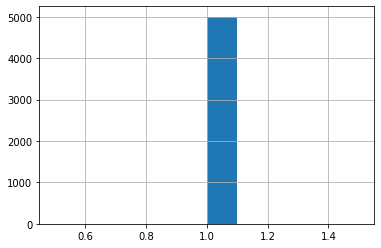

In [23]:
# Matrix should change

matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

Error metrics
count    4000.000000
mean        0.014561
std         0.000130
min         0.014198
25%         0.014471
50%         0.014551
75%         0.014641
max         0.015120
dtype: float64


<AxesSubplot:>

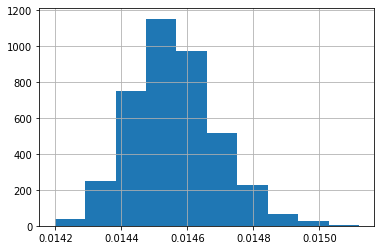

In [24]:
# Error will always be positive and integer, but is it skewed to the left? -> IT IS
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

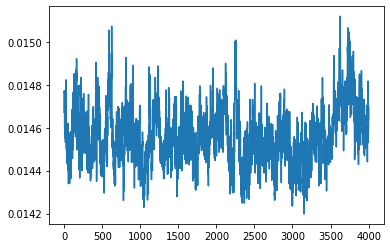

In [25]:
errors.plot()  # See if we still have a caterpillar

# We need to delete these checkings: 

E error metrics
count    4000.000000
mean      152.217547
std         6.231375
min       130.613935
25%       147.888471
50%       152.216950
75%       156.551908
max       173.729675
dtype: float64


Text(0.5, 1.0, 'E L2-error distribution')

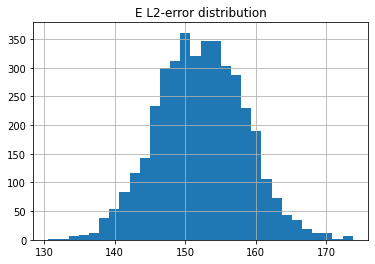

In [26]:
# Error should be distributed close to 0 (I guess...)
# BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target

E_errors = pd.Series(E_errors)
print("E error metrics")
print(E_errors.describe())
E_errors.hist(bins=30)
plt.title('E L2-error distribution')

Text(0.5, 1.0, 'E L2-error series')

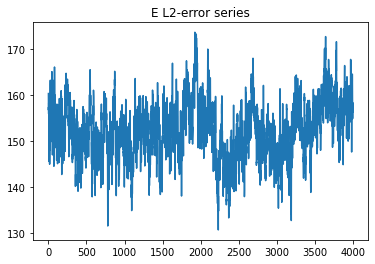

In [27]:
E_errors.plot()
plt.title('E L2-error series')

C error metrics
count    4000.000000
mean      239.868696
std        14.133580
min       191.666377
25%       230.277007
50%       240.272762
75%       250.068990
max       278.772309
dtype: float64


Text(0.5, 1.0, 'C L2-error distribution')

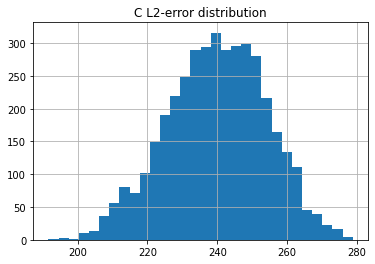

In [28]:
# Error should be distributed close to 0 (I guess...)
# BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
C_errors = pd.Series(C_errors)
print("C error metrics")
print(C_errors.describe())
C_errors.hist(bins=30)
plt.title('C L2-error distribution')

Text(0.5, 1.0, 'C L2-error series')

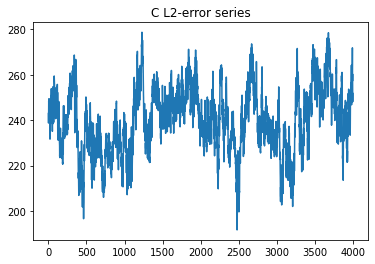

In [29]:
C_errors.plot()
plt.title('C L2-error series')